Speed calculation

In [16]:
xd = np.diff(x,append=np.nan)
yd = np.diff(y,append=np.nan)
td = np.diff(time,append=np.nan)

In [17]:
D = np.sqrt(xd**2 + yd**2) # calculate the distance run at each position tracked

In [18]:
speed = D/td # get speed from distance

model formula

In [ ]:
rate = np.maximum(0,speed*w + b + e)
plt.scatter(speed,rate)
plt.xlabel("Speed (cm/sec)")
plt.ylabel("Rate (Hz)")

Text(0, 0.5, 'Rate (Hz)')

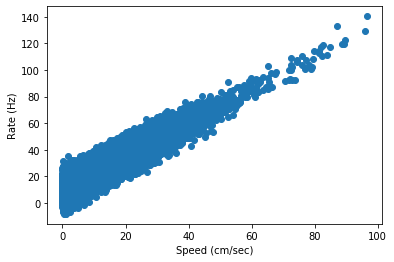

Untrain MSE

In [1]:
mse = np.mean((rate-yhat)**2)
# alternatively
mse = np.mean((rate-theta@x)**2)
print("MSE:",mse)

mse = np.mean((rate-yhat)**2)
mse

NameError: name 'np' is not defined

Trained model

In [ ]:
yhat = X@theta # predict the firing rate of the neuron using the optimize parameters

plt.scatter(speed,rate, label="Neuron")
plt.scatter(speed,yhat,label="Model")
plt.xlabel("Speed (cm/sec)")
plt.ylabel("Rate (Hz)")
plt.legend()
plt.show()

In [ ]:
yhat = X@theta # predict the firing rate of the neuron using the optimize parameters

fig, ax = plt.subplots(1,3,figsize=(14,4))

ax[0].scatter(speed,rate,label="Data")
ax[0].scatter(speed,untrained_yhat,label="Untrained Model")
ax[0].set_xlabel("Running speed (cm/sec)")
ax[0].set_ylabel("Firing rate (Hz)")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].legend()

ax[1].plot(mse)
ax[1].set_ylabel("Mean squared error (MSE)")
ax[1].set_xlabel("Iterations")
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)


ax[2].scatter(speed,rate,label="Data")
ax[2].scatter(speed,yhat,label="Trained Model")
ax[2].set_xlabel("Running speed (cm/sec)")
ax[2].set_ylabel("Firing rate (Hz)")
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].legend()

#fn = "../images/learning.png"
#plt.savefig(fn)


# HD cell training

In [1]:
import numpy as np
from scipy.optimize import minimize

# optimize() will try to minimize the value returned by objective_function()
# in our example, we can return the mean squared error of our model
def objective_function(x0,X,rate): 
    gain=x0[0]
    pref=x0[1]
    yhat = gain*(np.cos(X-pref)+1)/2 
    
    mse = np.mean((rate-yhat)**2)
    return mse

x0 = np.array([10, 1]) # parameters to optimize
             
results = minimize(objective_function,x0,args=(heading,rate))
print(results)

NameError: name 'heading' is not defined

In [330]:
import numpy as np
from scipy.optimize import minimize

# optimize() will try to minimize the value returned by objective_function()
# in our example, we can return the mean squared error of our model
def objective_function(x0,X,rate): 
    gain=x0[0]
    pref=x0[1]
    yhat = gain*(np.cos(X-pref)+1)/2 
    
    mse = np.mean((rate-yhat)**2)
    return mse

x0 = np.array([10, 1]) # parameters to optimize
             
results = minimize(objective_function,x0,args=(heading,rate))
print(results)

      fun: 3.4128918524449685
 hess_inv: array([[1.33740177, 0.00409226],
       [0.00409226, 0.04146408]])
      jac: array([-2.98023224e-08, -2.98023224e-08])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([10.03008571,  0.24848209])


In [331]:
import torch

# model making prediction
def model(X,delta):
    """
    X: head direction of the neuron as a 1D array (tensor)
    delta: 2 parameters, as a 1D array (tensor)
    """
    return delta[0] * (torch.cos(X-delta[1])+1)/2


# loss function returning MSE
def loss_fn(y,yhat):
    """
    Loss function, mean squared error
    
    y: observed values
    yhat: model predictions
    """
    squared_diff = (y-yhat)**2
    return squared_diff.mean()

# model parameters stored as a pytorch tensor, this makes the calculation of the gradients possible
delta = torch.tensor([5.0,2.0],requires_grad =True)
print("Initial delta:",delta)
# we transform our data from numpy array to pytorch tensors, no need for gradients

# xTensor is the heading, as a torch tensor
XTensor = torch.tensor(heading,dtype=torch.float32)
# rateTensor is the rate, as a torch tensor
rateTensor= torch.tensor(rate,dtype=torch.float32)


# let's run the model once and calculating the loss
yhat = model(XTensor,delta)
loss = loss_fn(yhat,rateTensor)
loss.backward()

print("gradients: ",delta.grad)

# we need to zero the gradients otherwise they accumulate
delta.grad.zero_()


Initial delta: tensor([5., 2.], requires_grad=True)
gradients:  tensor([-0.9342, 11.3924])


tensor([0., 0.])

In [332]:
## training loop that will modify our parameters to minimize the loss function (MSE)
def training_loop(n_epochs, learning_rate, delta, XTensor,rateTensor):
    for epoch in range (n_epochs):

        if delta.grad is not None:
            delta.grad.zero_() 
        
        yhat = model(XTensor,delta)
        loss = loss_fn(yhat,rateTensor)
        loss.backward()
        
        with torch.no_grad():
            delta -= learning_rate * delta.grad
        
        if epoch % 1000 ==0:
            print("Epoch: {}, Loss: {}".format(epoch,loss))
    return delta

In [333]:
opt_delta = training_loop(n_epochs = 10000,
                          learning_rate = 0.001,
                          delta = torch.tensor([5.0,2.0],requires_grad =True),
                          XTensor = XTensor,
                          rateTensor=rateTensor)
print(opt_delta)

Epoch: 0, Loss: 26.955976486206055
Epoch: 1000, Loss: 5.691333770751953
Epoch: 2000, Loss: 3.923570394515991
Epoch: 3000, Loss: 3.5273642539978027
Epoch: 4000, Loss: 3.4385528564453125
Epoch: 5000, Loss: 3.4186439514160156
Epoch: 6000, Loss: 3.4141814708709717
Epoch: 7000, Loss: 3.4131813049316406
Epoch: 8000, Loss: 3.412956714630127
Epoch: 9000, Loss: 3.4129068851470947
tensor([10.0271,  0.2485], requires_grad=True)
